In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = '/content/drive/MyDrive/A5/Mémoire/notebooks'
import sys
sys.path.append(ROOT)

# GPT-2

## Objectif

L'objectif de ce notebook est d'effectuer nos prédictions à l'aide d'une régression à l'aide de GPT-2.

## Import des librairies

In [ ]:
import os  # for path dirs and files
import tqdm  # progress bar


# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

import torch
import sklearn.model_selection

from dataset import Dataset

In [ ]:
%%capture
!python -m pip install transformers
from transformers import GPT2LMHeadModel, GPT2Config

## Import du dataset

Dans le notebook précédent numéro 3, nous avons créé une classe dataset pour simplifier les traitement. On peut donc l'importer.

In [ ]:
# import the dataset
dataset = Dataset(os.path.join(ROOT, 'data', 'data_optimized.csv'))
print(f'\nLength of the full dataset: {len(dataset)}\n')

Import file...
Convert day to date...
Convert columns to list...

Length of the full dataset: 225208



BLABLABLABLABLA
BLABLABLABLABLA

BLABLABLABLABLA

BLABLABLABLABLA
BLABLABLABLABLA

BLABLABLABLABLA

BLABLABLABLABLA
BLABLABLABLABLA

BLABLABLABLABLA

BLABLABLABLABLA
BLABLABLABLABLA

BLABLABLABLABLA

In [ ]:
N_TOKEN = 1000
mini, maxi = -0.03, 0.03

class Tokenizer:

    def __init__(self, mini=-0.03, maxi=0.03, n_token=1000):
        self.mini = mini
        self.maxi = maxi

        self.n_token = n_token
        self.step = (maxi - mini) / (n_token - 1)

    def tokenize(self, x):
        x = np.array(x)
        x = ((x - self.mini) / (self.maxi - self.mini) * (self.n_token - 1)).astype(np.int)
        x = np.clip(x, 0, self.n_token - 1)
        return list(x)

    def decode(self, x, is_torch=False):
        if is_torch:
            return x * self.step + self.mini
        x = np.array(x)
        x = np.array(x * self.step + self.mini)
        return x

        


tokenizer = Tokenizer(mini, maxi, N_TOKEN)

values = np.linspace(mini, maxi, 10)
print(values)
tokens = tokenizer.tokenize(values)
print(tokens)
decoded = tokenizer.decode(tokens)
print(decoded)


[-0.03       -0.02333333 -0.01666667 -0.01       -0.00333333  0.00333333
  0.01        0.01666667  0.02333333  0.03      ]
[0, 111, 222, 333, 444, 555, 666, 776, 888, 999]
[-0.03       -0.02333333 -0.01666667 -0.01       -0.00333333  0.00333333
  0.01        0.01660661  0.02333333  0.03      ]


Pour plus d'homogénéïté, nous standardiserons les données avec:
$$
\tilde{R_{t}} = \frac{R_{t} - \mu}{\sigma}
$$

$$
\mu = \frac{1}{240}\sum_{m=1}^{240} R_{0-m}
$$

$$
\sigma = \frac{1}{240}\sum_{m=1}^{240} (R_{0-m} - \mu)
$$

In [ ]:
%%time
tqdm.tqdm.pandas()
print('Compute the standardized rate of return in features...')
dataset.df['look_back_days'] = dataset.df.progress_apply(
    lambda row: list(tokenizer.tokenize(row['look_back_days']))
    if row['look_back_days'] == row['look_back_days'] else np.nan, 
    axis=1
)



/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/225208 [00:00<?, ?it/s]

Compute the standardized rate of return in features...


100%|██████████| 225208/225208 [00:43<00:00, 5190.49it/s]


CPU times: user 42.4 s, sys: 6.5 s, total: 48.9 s
Wall time: 44.3 s


Et on peut faire le split train/validation/test

In [ ]:
# split the dataset
training_dataset, validation_dataset, test_dataset = dataset.split()
print(f'Training part: {len(training_dataset)}')
print(f'Validation part: {len(validation_dataset)}')
print(f'Test part: {len(test_dataset)}')

Training part: 25647
Validation part: 23817
Test part: 159839


## Modèle LSTM


On peut donc se faire une petite classe pour la régression LSTM sur la base de la précédente faite en notebook 3.


https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72



In [ ]:
class GPT2:
    # /content/drive/MyDrive/A5/Mémoire/notebooks/final_gpt2.pth
    def __init__(self, *args, **kwargs):
        # give a name to the model
        self.name = 'gpt2'
        config = GPT2Config(vocab_size=N_TOKEN, max_length=240)
        self.model = GPT2LMHeadModel(config=config)
        self.model.load_state_dict(torch.load(os.path.join(ROOT, 'final_gpt2.pth')))

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        self.arange = torch.tensor([np.arange(N_TOKEN)]).to(self.device)



    def __call__(self, X):
        # prediction on the feature
        X = torch.from_numpy(np.array([X])).to(self.device)
        pred = self.model(X)
        pred = torch.nn.functional.softmax(pred.logits[..., -1, :], dim=-1)
        pred = (pred * self.arange).sum(dim=-1)
        pred = tokenizer.decode(pred, is_torch=True)[0].detach().cpu().numpy()

        return pred
    
    def fit_dataset(self, training_dataset, validation_dataset):
        # see notebook 10_model_gpt_preprocess.ipynb
        pass

    
    def valid_dataset(self, dataset):
        # see notebook 10_model_gpt_preprocess.ipynb
        pass
    
    
    def _predict_row(self, row):
        
        # predict the row only if it is not Nan of course
        if row.look_back_days != row.look_back_days:
            return np.nan
        else:
            return self.__call__(row.look_back_days)
        
    def predict_all_dataset(self, dataset, progress_bar=True):
        with torch.no_grad():
            # get the primary keys (pair and day) and info (return and set) from the dataset
            predictions_df = pd.DataFrame(dataset.df[['pair', 'day', 'return', 'set']])
            
            # run the prediction all along the dataset and return it as a dataframe of predictions
            if progress_bar:
                tqdm.tqdm.pandas()
                predictions_df[self.name] = dataset.df.progress_apply(self._predict_row, axis=1)
            else:
                predictions_df[self.name] = dataset.df.apply(self._predict_row, axis=1)        
            
        return predictions_df
            
model = GPT2()

## Prédiction sur tout le dataset et analyse

Maintenant que notre modèle est entrainé, on peut faire les prédictions sur tout le dataset. 

In [ ]:
predictions_df = model.predict_all_dataset(dataset)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 225208/225208 [57:18<00:00, 65.49it/s]


Maintenant on peut afficher la distribution des prédictions en fonction des ground truth 

In [ ]:
def plot_scatter_and_hist(predictions_df, filter_set=None, color='#0593ba', label='', axes=None):

    # definition for set(s) to plot    
    if filter_set is not None: # no filter
        if isinstance(filter_set, str): # convert to list if it is string to be homogeneous
            filter_set = [filter_set]
        # make the filter on the set(s)
        predictions_df = predictions_df[predictions_df['set'].isin(filter_set)]
    # drop Nan values 
    predictions_df = predictions_df.dropna()

    # definitions for the axes
    if axes is None:
        # set the axes dimensions
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005
        
        # compute their rectangle
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]
        ax_scatter = plt.axes(rect_scatter)
        
        # create the axes
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histy = plt.axes(rect_histy)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy.tick_params(direction='in', labelleft=False)
        
        ax_scatter.set_xlabel('True')
        ax_scatter.set_ylabel('Prediction')
        
        # add the zero's lines to be more comprehensive
        ax_scatter.axvline(x=0, color='#000000', alpha=0.3)
        ax_scatter.axhline(y=0, color='#000000', alpha=0.3)
        ax_histx.axvline(  x=0, color='#000000', alpha=0.3)
        ax_histy.axhline(  y=0, color='#000000', alpha=0.3)
    else:
        ax_scatter, ax_histx, ax_histy = axes
        

    # the scatter plot
    ax_scatter.scatter(predictions_df['return'], predictions_df[model.name], color=color, alpha=0.01)
    
    # the histograms
    bins = 100
    ax_histx.hist(predictions_df['return'], bins=bins, density=True, color=color, alpha=0.3, label=label)
    ax_histy.hist(predictions_df[model.name], bins=bins, density=True, color=color, alpha=0.3, orientation='horizontal')
    
    # set the limit on histograms to have its axis aligned to the scatter plot
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    return ax_scatter, ax_histx, ax_histy
    

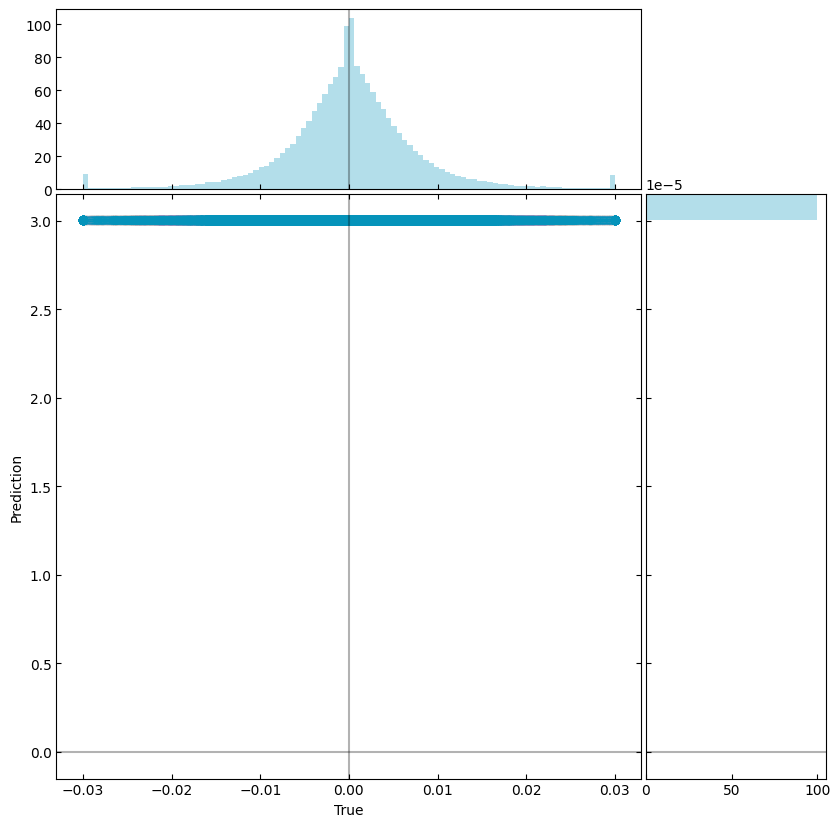

In [ ]:
plt.rcParams['figure.figsize'] = [9, 9]    
plot_scatter_and_hist(predictions_df)
plt.rcParams['figure.figsize'] = [12, 4]

pass

Il est encore pertinent de visualiser si la distribution des erreurs est normale ou non. Du moins, vérifier si elle est centrée en zéro et interpréter sont applatissement.

A noter que l'erreur est donnée par la formule suivante:

$error = \hat{R_{0}} - R_{0}$

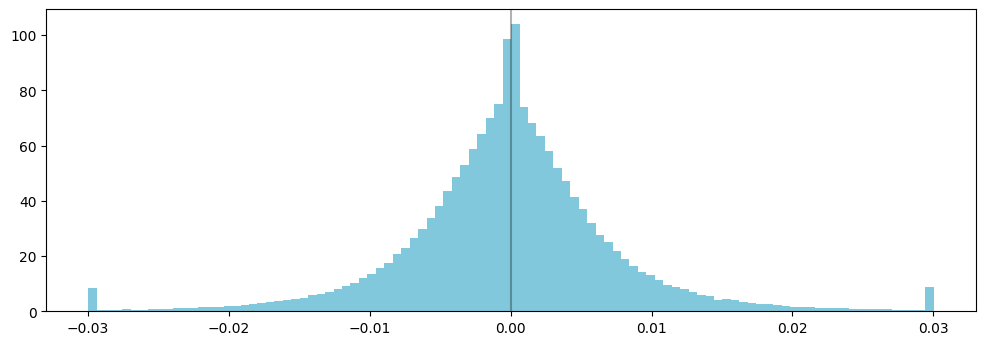

In [ ]:
error = predictions_df[model.name] - predictions_df['return']
plt.hist(error, bins=100, density=True, color='#0593ba', alpha=0.5)
plt.axvline(x=0, color='#000000', alpha=0.3)

pass

Et enfin, on peut s'attarder sur les métriques statistiques globales et par split de dataset

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
error_table = error.agg(['mean', 'std', 'skew', 'kurt']).reset_index()
error_table

,index,0
0,mean,-0.00006207
1,std,0.00750818
2,skew,0.03684025
3,kurt,3.22955917


In [ ]:
set_df = predictions_df[predictions_df['set'] != 'unpredictable'][['set']]
set_df['error'] = error
pd.options.display.float_format = "{0:.8f}".format
error_table = set_df.groupby(['set']).agg({'error':['mean', 'std', pd.Series.skew, pd.Series.kurt]}).reset_index()
error_table

DataError: ignored

In [ ]:
pd.options.display.float_format = None

## Sauvegarde des données

Ne reste plus qu'à sauvegarder nos données. 

Pour cela, on reprend les fichier `results.csv` établit lors du notebook précédent et on y joint les nouvelles prédiction du modèle de ce notebook

In [ ]:
model.name = 'gpt2'
predictions_df['gpt2'] = predictions_df['gpt-2']

In [ ]:
df = pd.read_csv(os.path.join(ROOT, 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates

# can be useufl when reloaded
if model.name in df.columns:
    df = df.drop(columns=model.name)
df

,pair,day,return,set,naive,linear_regression,knn_regressor,rf_regressor,dnn,lstm
0,AUDCAD,2007-10-23,0.007541,unpredictable,nan,nan,nan,nan,nan,nan
1,AUDCAD,2007-10-24,0.003915,unpredictable,nan,nan,nan,nan,nan,nan
2,AUDCAD,2007-10-25,0.002523,unpredictable,nan,nan,nan,nan,nan,nan
3,AUDCAD,2007-10-26,0.005835,unpredictable,nan,nan,nan,nan,nan,nan
4,AUDCAD,2007-10-29,0.007962,unpredictable,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,-0.001028,-0.000169,0.001145
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.000891,0.001152,0.000113
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.000494,0.000526,0.000157
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,0.001143,0.002579,0.000902


In [ ]:
df = df.merge(predictions_df[['pair', 'day', model.name]], how='inner', on=['pair', 'day'])
df

,pair,day,return,set,naive,linear_regression,knn_regressor,rf_regressor,dnn,lstm,gpt2
0,AUDCAD,2007-10-23,0.007541,unpredictable,nan,nan,nan,nan,nan,nan,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,nan,nan,nan,nan,nan,nan,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,nan,nan,nan,nan,nan,nan,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,nan,nan,nan,nan,nan,nan,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,nan,nan,nan,nan,nan,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,-0.001028,-0.000169,0.001145,3.0031428e-05
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.000891,0.001152,0.000113,3.0031428e-05
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.000494,0.000526,0.000157,3.0031428e-05
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,0.001143,0.002579,0.000902,3.0031428e-05


Avant de sauvegarder, on peut quand même s'amuser à comparer les prédictions desmodèles à cette étape

In [ ]:
# pd.options.display.float_format = "{0:.6f}".format
df.drop(columns=['pair', 'day', 'return']).groupby('set').agg(['mean', 'std', pd.Series.skew, pd.Series.kurt]).reset_index().transpose()

0         1              2           3
set                         test  training  unpredictable  validation
naive             mean  0.000118  0.000035            NaN   -0.000012
                  std   0.007911  0.006061            NaN    0.006012
                  skew -0.033118 -0.085883            NaN   -0.076113
                  kurt  2.974460  2.633147            NaN    3.822572
linear_regression mean  0.000087  0.000012            NaN   -0.000025
                  std   0.000599  0.000486            NaN    0.000464
                  skew  0.025856 -0.088439            NaN   -0.416042
                  kurt  4.617782  1.490406            NaN    2.115215
knn_regressor     mean  0.000191  0.000099            NaN    0.000062
                  std   0.002669  0.002271            NaN    0.002101
                  skew  0.048623  0.049620            NaN   -0.087633
                  kurt  3.730894  4.064949            NaN    5.710044
rf_regressor      mean  0.000086  0.000025            NaN   -0.000029
                  std   0.000862  0.003871            NaN    0.000733
                  skew -0.082723 -0.109116            NaN   -0.746696
                  kurt  6.068632  2.662977            NaN   14.812537
dnn               mean  0.000159  0.000067            NaN    0.000038
                  std   0.001354  0.001176            NaN    0.001091
                  skew  0.318284  0.275281            NaN    0.750367
                  kurt 20.486778 29.665607            NaN   55.194727
lstm              mean  0.000311  0.000197            NaN    0.000147
                  std   0.000823  0.000635            NaN    0.000624
                  skew  0.360531  0.170890            NaN   -0.022999
                  kurt  6.135163  6.056974            NaN    9.794684

In [ ]:
np.unique(df['gpt2'])

16427

In [ ]:
df.to_csv(os.path.join(ROOT, 'data', 'results.csv'), index=False)

## Sanity check

In [ ]:
df = pd.read_csv(os.path.join(ROOT, 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates
df

In [ ]:
cols = ['naive', 'linear_regression', 'knn_regressor', 'rf_regressor', 'dnn', 'lstm']
for col in cols:
    df[col] = ((df[col] - df['return'])**2)**1/2 *100


In [ ]:
df.drop(columns=['pair', 'day', 'return']).groupby('set').agg(['mean', 'std', pd.Series.skew, pd.Series.kurt]).reset_index().transpose()